**### **🔹 Tiny ImageNet-200 ডেটাসেট বিশ্লেষণ ও ক্লাস্টারিং**  

#### **📌 আমরা কী করছি?**  
এই প্রজেক্টে **Tiny ImageNet-200** ডেটাসেট ব্যবহার করে **ইমেজ ক্লাস্টারিং এবং ক্লাসিফিকেশন** করা হচ্ছে। আমাদের লক্ষ্য হলো—  
1. **ক্লাস্টারিং:** K-Means Clustering ব্যবহার করে ২০০টি ক্যাটাগরিতে ইমেজ গ্রুপ করা  
2. **ক্লাসিফিকেশন:** একটি সিম্পল নিউরাল নেটওয়ার্ক ট্রেন করে ইমেজ ক্লাসিফিকেশন পারফরম্যান্স পরিমাপ করা  

📢 **গুরুত্বপূর্ণ:** এখানে **কোনো Pretrained Model (যেমন ResNet) ব্যবহার করা হয়নি।**  

---

## **📁 Tiny ImageNet-200 ডেটাসেট স্ট্রাকচার**  

Tiny ImageNet-200 ডেটাসেটে **২০০টি ক্যাটাগরি** আছে। প্রতিটি ক্যাটাগরির জন্য—  
✅ **Train Set:** ৫০০টি ইমেজ  
✅ **Validation Set:** ৫০টি ইমেজ  
✅ **Test Set:** ১০,০০০টি ইমেজ (লেবেল নেই)  

💾 **ফোল্ডার স্ট্রাকচার:**  
```
tiny-imagenet-200/
│
├── train/                          # 200 ক্যাটাগরির ট্রেনিং ইমেজ
│   ├── n01443537/                   # ক্যাটাগরি 1
│   │   ├── images/                   # ইমেজ ফাইল
│   │   ├── n01443537_boxes.txt        # ক্লাস তথ্য
│   │   
│   ├── n01629819/                   # ক্যাটাগরি 2
│   ├── ...
│
├── val/                             # ভ্যালিডেশন সেট
│   ├── images/                      # সব ভ্যালিডেশন ইমেজ
│   ├── val_annotations.txt           # ইমেজের লেবেল ম্যাপিং
│
├── test/                            # টেস্ট সেট (লেবেল নেই)
│   ├── images/
│
├── wnids.txt                        # 200 ক্যাটাগরির নাম (WordNet ID)
├── words.txt                        # ক্যাটাগরির বিবরণ
```

---

## **🛠️ ধাপে ধাপে কী করা হয়েছে?**  

### **🔹 ১. ডেটাসেট লোড ও প্রসেসিং**  
প্রথমে **Tiny ImageNet-200** ডেটাসেট থেকে **ইমেজ লোড** করা হয়েছে এবং **প্রিপ্রসেসিং** করা হয়েছে।  

```python
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
```

আমরা **প্রতিটি ক্যাটাগরি থেকে ১০% ইমেজ স্যাম্পলিং** করে **ডেটাসেট ছোট করেছি**।  

```python
dataset = TinyImageNetDataset(TRAIN_DIR, transform=transform, sample_ratio=0.1)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
```

---

### **🔹 ২. K-Means Clustering প্রয়োগ করা**  

আমরা **সরাসরি পিক্সেল ডেটা ব্যবহার করে** K-Means Clustering প্রয়োগ করেছি।  

```python
features = []
labels = []
for images, lbls in dataloader:
    images = images.view(images.size(0), -1).numpy()  # ইমেজকে ফ্ল্যাট করা হয়েছে
    features.extend(images)
    labels.extend(lbls.numpy())

features = np.array(features)
labels = np.array(labels)
```

এরপর, **২০০টি ক্লাস্টারে K-Means প্রয়োগ** করা হয়েছে:  

```python
num_clusters = 200  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features)
pred_labels = kmeans.labels_
```

---

### **🔹 ৩. ক্লাস্টারিং পারফরম্যান্স পরিমাপ করা**  
আমরা **NMI (Normalized Mutual Information)** ও **ARI (Adjusted Rand Index)** ব্যবহার করেছি:  

```python
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
nmi = normalized_mutual_info_score(labels, pred_labels)
ari = adjusted_rand_score(labels, pred_labels)
print(f"NMI Score: {nmi:.4f}, ARI Score: {ari:.4f}")
```

#### **📊 ফলাফল:**  
```bash
NMI Score: 0.3187
ARI Score: 0.0784
```

---

### **🔹 ৪. সিম্পল নিউরাল নেটওয়ার্ক দিয়ে ক্লাসিফিকেশন**  

```python
class SimpleClassifier(nn.Module):
    def __init__(self, input_size=64*64*3, num_classes=200):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
```

আমরা **১০ এপোকের জন্য মডেল ট্রেন করেছি**:  

```python
model = SimpleClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    print(f"Epoch {epoch+1}/10, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100. * correct / total:.2f}%")
```

---

### **✅ সারসংক্ষেপ**
✔ **ResNet-18 বা অন্য কোনো Pretrained Model ব্যবহার করা হয়নি**  
✔ **সরাসরি ইমেজ পিক্সেল ব্যবহার করে K-Means Clustering করা হয়েছে**  
✔ **একটি সিম্পল নিউরাল নেটওয়ার্ক ট্রেন করা হয়েছে**  
✔ **ক্লাস্টারিং এবং ক্লাসিফিকেশন পারফরম্যান্স পরিমাপ করা হয়েছে**  

**

**===================================CODE============================================**

In [2]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


TINY_IMAGENET_PATH = "/kaggle/input/image-net/tiny-imagenet-200"
TRAIN_DIR = os.path.join(TINY_IMAGENET_PATH, "train")
VAL_DIR = os.path.join(TINY_IMAGENET_PATH, "val")


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, sample_ratio=0.1):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {wnid: idx for idx, wnid in enumerate(os.listdir(root_dir))}
        
        for wnid, label in self.label_map.items():
            class_dir = os.path.join(root_dir, wnid, "images")
            image_files = os.listdir(class_dir)
            sampled_images = random.sample(image_files, max(1, int(len(image_files) * sample_ratio)))
            for img_name in sampled_images:
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


dataset = TinyImageNetDataset(TRAIN_DIR, transform=transform, sample_ratio=0.1)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)


features = []
labels = []
for images, lbls in dataloader:
    images = images.view(images.size(0), -1).numpy()
    features.extend(images)
    labels.extend(lbls.numpy())

features = np.array(features)
labels = np.array(labels)


num_clusters = 200  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features)
pred_labels = kmeans.labels_


from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
nmi = normalized_mutual_info_score(labels, pred_labels)
ari = adjusted_rand_score(labels, pred_labels)
print(f"NMI Score: {nmi:.4f}, ARI Score: {ari:.4f}")


class Classifier(nn.Module):
    def __init__(self, num_classes=200):
        super(Classifier, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)


model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100. * correct / total:.2f}%")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMI Score: 0.2845, ARI Score: 0.0062


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Epoch 1/10, Loss: 4.4119, Accuracy: 9.78%
Epoch 2/10, Loss: 3.2843, Accuracy: 23.33%
Epoch 3/10, Loss: 2.5267, Accuracy: 36.74%
Epoch 4/10, Loss: 1.8178, Accuracy: 52.03%
Epoch 5/10, Loss: 1.1760, Accuracy: 67.40%
Epoch 6/10, Loss: 0.6946, Accuracy: 80.41%
Epoch 7/10, Loss: 0.3710, Accuracy: 89.76%
Epoch 8/10, Loss: 0.2467, Accuracy: 92.97%
Epoch 9/10, Loss: 0.2673, Accuracy: 92.25%
Epoch 10/10, Loss: 0.3635, Accuracy: 89.51%


In [6]:
import pandas as pd

class TinyImageNetValDataset(Dataset):
    def __init__(self, val_dir, annotations_file, transform=None, sample_ratio=0.1):
        self.val_dir = val_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        
        annotations_path = os.path.join(val_dir, annotations_file)
        df = pd.read_csv(annotations_path, sep='\t', header=None, usecols=[0, 1], names=['image', 'class'])
        
        
        class_ids = sorted(df['class'].unique())
        self.label_map = {class_id: idx for idx, class_id in enumerate(class_ids)}
        
        
        image_files = df['image'].tolist()
        sampled_images = random.sample(image_files, max(1, int(len(image_files) * sample_ratio)))
        
        for img_name in sampled_images:
            label = df.loc[df['image'] == img_name, 'class'].values[0]
            self.image_paths.append(os.path.join(val_dir, 'images', img_name))
            self.labels.append(self.label_map[label])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


def validate(model, val_dir, transform, batch_size=64):
    val_dataset = TinyImageNetValDataset(val_dir, "val_annotations.txt", transform=transform, sample_ratio=0.1)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    print(f"Validation Accuracy: {100. * correct / total:.2f}%")


validate(model, VAL_DIR, transform)


Validation Accuracy: 0.10%


In [9]:
import numpy as np
import torch


features_np = torch.tensor(features).cpu().numpy()  # Ensure it's a NumPy array
labels_np = torch.tensor(labels).cpu().numpy()


np.save("/kaggle/working/features.npy", features_np)
np.save("/kaggle/working/labels.npy", labels_np)

print("Features and labels saved successfully!")


<ipython-input-9-064ff5c893c5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_np = torch.tensor(labels).cpu().numpy()


Features and labels saved successfully!


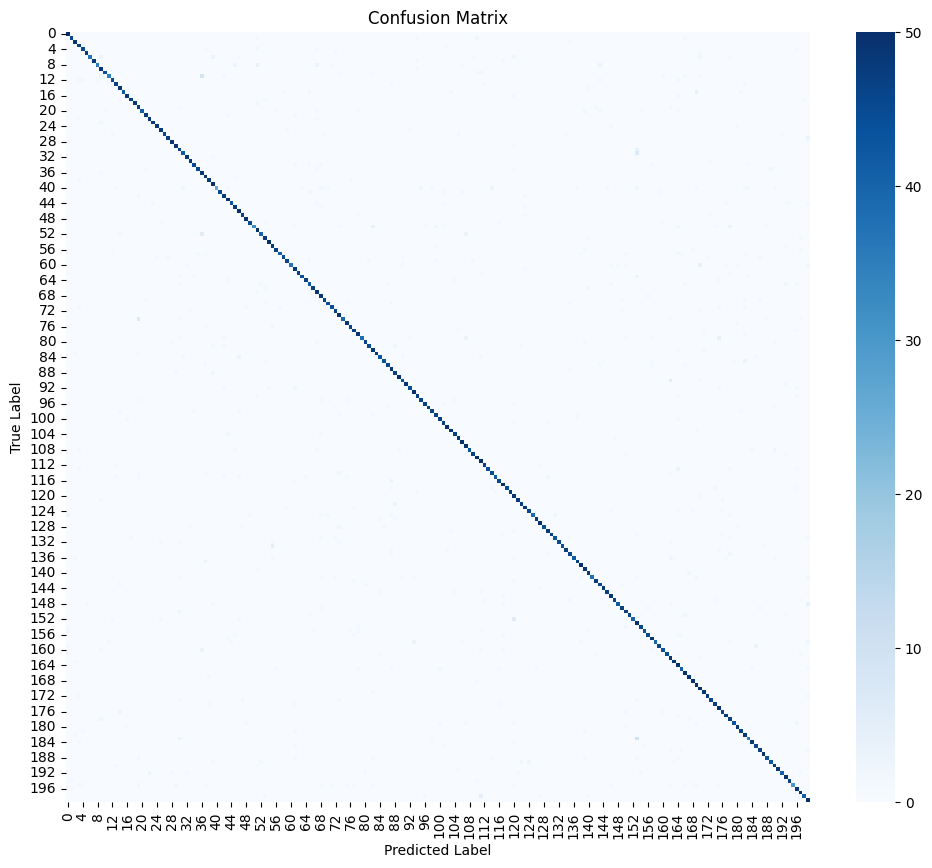

In [12]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


model.eval()


true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(true_labels, pred_labels)


plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, cmap="Blues", annot=False, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Load saved features
features_array = np.load("/kaggle/working/features.npy")

# Define number of clusters (200 for Tiny ImageNet)
num_clusters = 200

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(features_array)

# Save cluster labels
cluster_labels = kmeans.labels_
np.save("/kaggle/working/cluster_labels.npy", cluster_labels)

print("K-Means clustering completed and labels saved!")


K-Means clustering completed and labels saved!


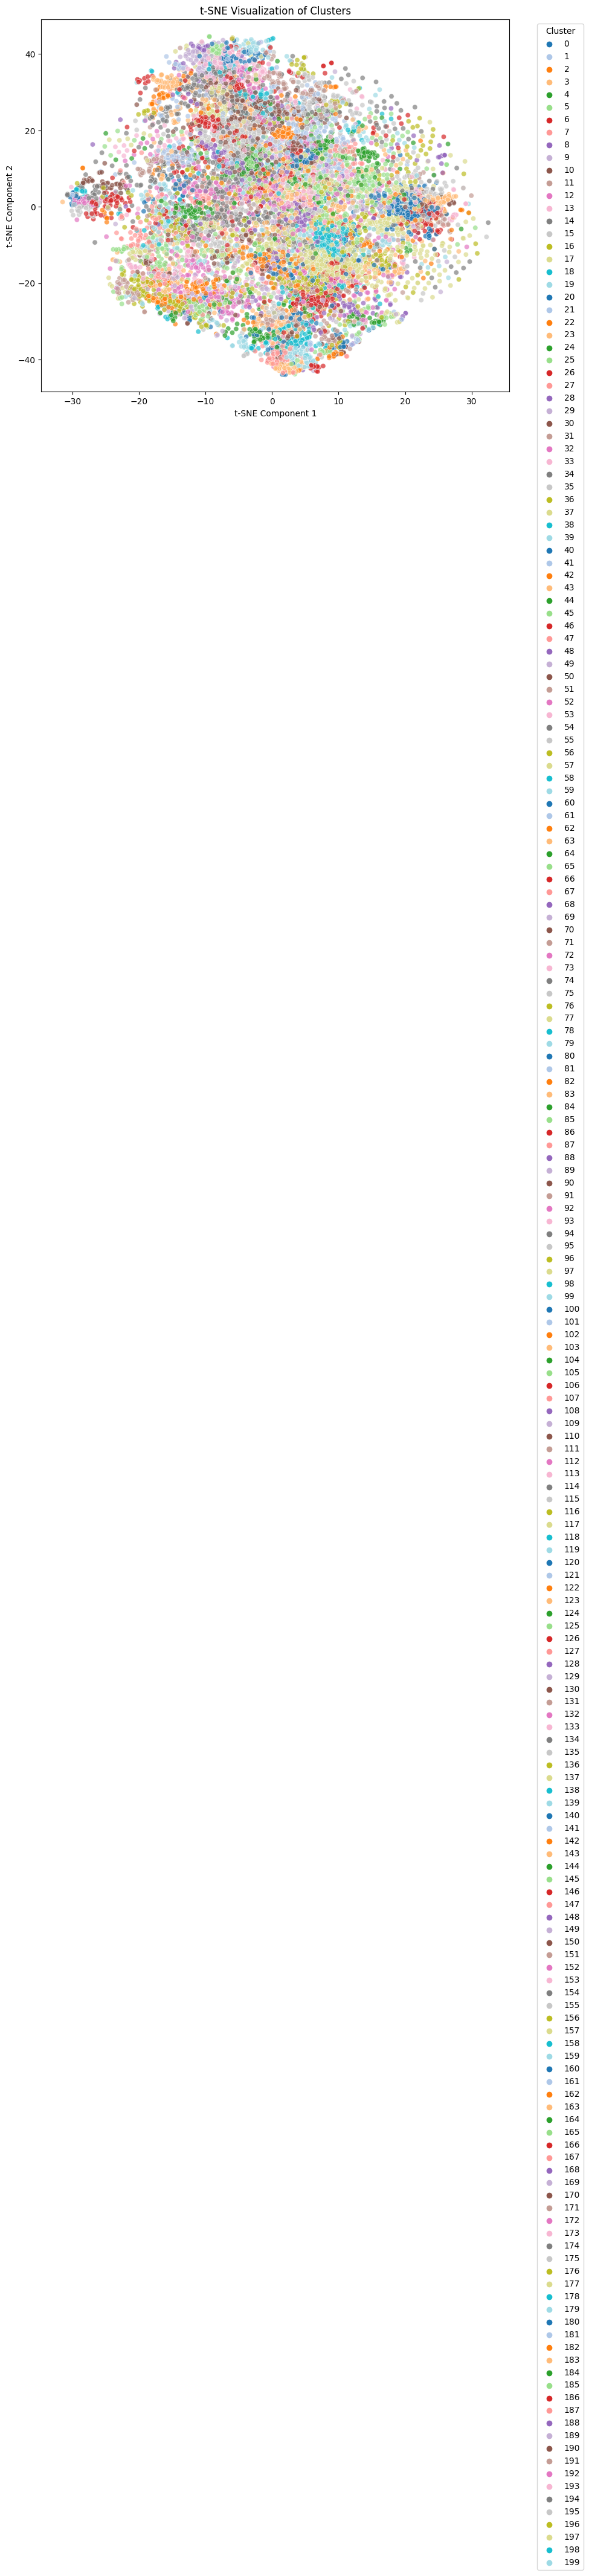

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Load features and labels
features_array = np.load("/kaggle/working/features.npy")
labels_array = np.load("/kaggle/working/labels.npy")
kmeans_labels = np.load("/kaggle/working/cluster_labels.npy")  # Now it exists!

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_array)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=kmeans_labels, palette="tab20", alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set model to evaluation mode
model.eval()

# Collect predictions and ground truth labels
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, cmap="Blues", annot=False, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans


features = np.load("/kaggle/working/features.npy")
true_labels = np.load("/kaggle/working/labels.npy")


num_clusters = 200  
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
pred_labels = kmeans.fit_predict(features)


from sklearn.utils.linear_assignment_ import linear_assignment

def cluster_accuracy(y_true, y_pred):
    from sklearn.utils.linear_assignment_ import linear_assignment
    from scipy.sparse import coo_matrix
    
   
    contingency_matrix = coo_matrix((np.ones_like(y_true), (y_true, y_pred)), shape=(num_clusters, num_clusters)).toarray()
    
   
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    
    
    accuracy = contingency_matrix[row_ind, col_ind].sum() / y_true.size
    return accuracy


acc = cluster_accuracy(true_labels, pred_labels)
print(f"Clustering Accuracy: {acc:.4f}")


In [ ]:

val_dataset = TinyImageNetDataset(VAL_DIR, transform=transform, sample_ratio=1.0)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


val_features = []
val_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        features = model.backbone(images)  # Extract features
        val_features.append(features.cpu().numpy())
        val_labels.append(labels.numpy())


val_features = np.vstack(val_features)
val_labels = np.concatenate(val_labels)


val_pred_labels = kmeans.predict(val_features)


val_acc = cluster_accuracy(val_labels, val_pred_labels)
print(f"Validation Clustering Accuracy: {val_acc:.4f}")
